In [8]:
!pip install transformers accelerate datasets seqeval --quiet
!pip install git+https://github.com/kmkurn/pytorch-crf.git --quiet
!pip install rich --quiet
!pip install sentencepiece --quiet

  Preparing metadata (setup.py) ... done


In [9]:
import os
import random
import json
from typing import List, Tuple, Dict, Any
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torchcrf import CRF

from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [10]:
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# Hyperparameters (tune to GPU)
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 4
LR = 3e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
LABELS = ["O", "B-ASP", "I-ASP"]
label2id = {l:i for i,l in enumerate(LABELS)}
id2label = {i:l for l,i in label2id.items()}

print("Labels:", label2id)


Labels: {'O': 0, 'B-ASP': 1, 'I-ASP': 2}


In [11]:
def safe_int(x, default= -1):
    try:
        return int(x)
    except:
        return default

def normalize_span(start:int, end:int, text:str):
    """
    Clips and sanity-checks a char span to be inside text.
    Returns (start,end) or None if invalid.
    """
    if start is None or end is None:
        return None
    if start < 0: start = 0
    if end > len(text): end = len(text)
    if start >= end:
        return None
    # optionally strip leading/trailing spaces inside the span
    # move start forward over spaces
    while start < end and text[start].isspace():
        start += 1
    while end > start and text[end-1].isspace():
        end -= 1
    if start >= end:
        return None
    return (start, end)

In [12]:
DATA_PATH = "/content/Laptop_Train_v2.csv"  # change if needed
assert os.path.exists(DATA_PATH), f"{DATA_PATH} not found. Please upload file to Colab."

raw_df = pd.read_csv(DATA_PATH, dtype=str).fillna("")  # read everything as str to avoid dtype issues
raw_df.columns = [c.strip() for c in raw_df.columns]
raw_df.head(5)

id                                           Sentence     Aspect Term  \
0  2339  I charge it at night and skip taking the cord ...            cord   
1  2339  I charge it at night and skip taking the cord ...    battery life   
2  1316  The tech guy then said the service center does...  service center   
3  1316  The tech guy then said the service center does...    "sales" team   
4  1316  The tech guy then said the service center does...        tech guy   

   polarity from   to  
0   neutral   41   45  
1  positive   74   86  
2  negative   27   41  
3  negative  109  121  
4   neutral    4   12

In [13]:
cols = [c.lower() for c in raw_df.columns]
def find_col(possible):
    for p in possible:
        if p in cols:
            return raw_df.columns[cols.index(p)]
    return None

SENT_COL = find_col(["sentence","text","review","sent"])
FROM_COL = find_col(["from","start","start_idx","startindex","begin"])
TO_COL = find_col(["to","end","end_idx","endindex"])
ASP_COL = find_col(["aspect term","aspect","aspect_term","aspect_term(s)","aspectterm"])
ID_COL = find_col(["id","sentence_id","sid","review_id"])

print("Detected columns:", {"SENT":SENT_COL,"FROM":FROM_COL,"TO":TO_COL,"ASP":ASP_COL,"ID":ID_COL})

# Build aggregated examples dict keyed by (id or sentence text)
examples = {}  # key -> {"sentence": str, "spans":[(start,end,text),...]}
for idx, row in raw_df.iterrows():
    sent = str(row[SENT_COL]) if SENT_COL else ""
    if not sent:
        continue
    key = str(row[ID_COL]) if ID_COL else sent.strip()
    # attempt parse span ints
    start = safe_int(row[FROM_COL]) if FROM_COL else -1
    end = safe_int(row[TO_COL]) if TO_COL else -1
    asp_text = str(row[ASP_COL]).strip() if ASP_COL else ""
    # normalize
    if key not in examples:
        examples[key] = {"sentence": sent, "spans": []}
    # If there is a valid numeric span, normalize and add
    s_norm = normalize_span(start, end, sent)
    if s_norm:
        s,e = s_norm
        examples[key]["spans"].append((s,e, sent[s:e]))
    else:
        # If no numeric span but aspect text exists, attempt to find a substring match (first occurrence)
        if asp_text:
            # try to find the first occurrence - safe fallback (may be ambiguous)
            pos = sent.find(asp_text)
            if pos != -1:
                examples[key]["spans"].append((pos, pos + len(asp_text), asp_text))
            else:
                # Could not find — skip but log
                # optionally store as a failed annotation for manual check
                pass

print("Loaded sentence examples:", len(examples))
# convert to list
examples_list = list(examples.values())
examples_list[:2]


Detected columns: {'SENT': 'Sentence', 'FROM': 'from', 'TO': 'to', 'ASP': 'Aspect Term', 'ID': 'id'}
Loaded sentence examples: 1488


[{'sentence': 'I charge it at night and skip taking the cord with me because of the good battery life.',
  'spans': [(41, 45, 'cord'), (74, 86, 'battery life')]},
 {'sentence': 'The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the "sales" team, which is the retail shop which I bought my netbook from.',
  'spans': [(27, 41, 'service center'),
   (109, 121, '"sales" team'),
   (4, 12, 'tech guy')]}]

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
print("Tokenizer fast:", tokenizer.is_fast)

def tokenize_with_offsets(text: str, max_len: int = MAX_LEN):
    """
    Returns a dict: input_ids, attention_mask, offset_mapping (list), token_type_ids if present
    offset_mapping is list of (start,end) per token in the returned token sequence (including special tokens)
    """
    enc = tokenizer(
        text,
        truncation=True,
        max_length=max_len,
        return_offsets_mapping=True,
        padding=False,   # we'll pad later in collate
        return_attention_mask=True
    )
    # offset_mapping is a list of tuples
    return enc


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer fast: True


In [15]:
def char_spans_to_token_labels(offsets: List[Tuple[int,int]], spans: List[Tuple[int,int]]):
    """
    offsets: list of (start,end) per token (including special tokens with (0,0))
    spans: list of (char_start,char_end) gold aspect spans (already normalized)
    returns: labels list aligned to offsets using BIO semantics (string labels)
    """
    N = len(offsets)
    labels = ["O"] * N
    span_mask = [False] * N

    # mark tokens whose offsets overlap any span
    for a_start, a_end in spans:
        for i, (t_start, t_end) in enumerate(offsets):
            if t_start == t_end == 0:
                continue  # special token
            # overlap check: not disjoint
            if not (t_end <= a_start or t_start >= a_end):
                span_mask[i] = True

    # create B/I tags from contiguous True segments in span_mask
    prev = False
    for i in range(N):
        if span_mask[i]:
            if not prev:
                labels[i] = "B-ASP"
            else:
                labels[i] = "I-ASP"
            prev = True
        else:
            labels[i] = "O"
            prev = False
    return labels


In [16]:
processed = []
skipped = 0
for ex in tqdm(examples_list, desc="Preprocessing"):
    text = ex["sentence"]
    spans = [(s,e) for s,e,_ in ex["spans"]]
    enc = tokenize_with_offsets(text, max_len=MAX_LEN)
    offsets = enc["offset_mapping"]  # list of (start,end)
    # normalize spans again with respect to truncation: if tokenization truncated text, drop spans beyond max_len
    # find last non-zero offset index to find the real text covered by tokenizer (or simpler: check token offsets)
    # We'll drop spans that have no overlapping token offsets (i.e., truncated out)
    filtered_spans = []
    for s,e in spans:
        # check if any token offset overlaps this span
        overlap_any = False
        for (t_s, t_e) in offsets:
            if t_s==t_e==0:
                continue
            if not (t_e <= s or t_s >= e):
                overlap_any = True
                break
        if overlap_any:
            filtered_spans.append((s,e))
    if len(spans) > 0 and len(filtered_spans) == 0:
        # all spans truncated away — skip example (or keep with empty spans)
        skipped += 1
        filtered_spans = []
    labels = char_spans_to_token_labels(offsets, filtered_spans)
    # convert labels to ids
    label_ids = [label2id[l] for l in labels]
    item = {
        "sentence": text,
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "labels": label_ids,
        "offset_mapping": offsets  # preserve original offsets for exact char mapping
    }
    processed.append(item)
print("Processed:", len(processed), "Skipped due to truncation:", skipped)
# optional sanity print
processed[0]


Preprocessing:   0%|          | 0/1488 [00:00<?, ?it/s]

Processed: 1488 Skipped due to truncation: 0


{'sentence': 'I charge it at night and skip taking the cord with me because of the good battery life.',
 'input_ids': [101,
  1045,
  3715,
  2009,
  2012,
  2305,
  1998,
  13558,
  2635,
  1996,
  11601,
  2007,
  2033,
  2138,
  1997,
  1996,
  2204,
  6046,
  2166,
  1012,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0],
 'offset_mapping': [(0, 0),
  (0, 1),
  (2, 8),
  (9, 11),
  (12, 14),
  (15, 20),
  (21, 24),
  (25, 29),
  (30, 36),
  (37, 40),
  (41, 45),
  (46, 50),
  (51, 53),
  (54, 61),
  (62, 64),
  (65, 68),
  (69, 73),
  (74, 81),
  (82, 86),
  (86, 87),
  (0, 0)]}

In [17]:
train_items, val_items = train_test_split(processed, test_size=0.1, random_state=SEED)
print("Train items:", len(train_items), "Val items:", len(val_items))

class ATE_Dataset(Dataset):
    def __init__(self, items):
        self.items = items
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        return self.items[idx]

def collate_fn(batch: List[Dict[str,Any]]):
    # pad to max length in batch
    max_len = max(len(x["input_ids"]) for x in batch)
    input_ids = []
    attention_mask = []
    labels = []
    offset_mappings = []
    sentences = []
    for x in batch:
        l = len(x["input_ids"])
        pad_len = max_len - l
        input_ids.append(x["input_ids"] + [tokenizer.pad_token_id]*pad_len)
        attention_mask.append(x["attention_mask"] + [0]*pad_len)
        labels.append(x["labels"] + [label2id["O"]]*pad_len)
        # extend offset mappings by (0,0) for padded tokens to preserve alignment length
        offset_mappings.append(x["offset_mapping"] + [(0,0)]*pad_len)
        sentences.append(x["sentence"])
    batch_out = {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
        "labels": torch.tensor(labels, dtype=torch.long),
        "offset_mappings": offset_mappings,
        "sentences": sentences
    }
    return batch_out

train_ds = ATE_Dataset(train_items)
val_ds = ATE_Dataset(val_items)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


Train items: 1339 Val items: 149


In [18]:
class BertCRFForATE(nn.Module):
    def __init__(self, model_name: str, num_labels: int, dropout_prob:float=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        seq_out = outputs.last_hidden_state  # (batch, seq_len, hidden)
        seq_out = self.dropout(seq_out)
        emissions = self.classifier(seq_out)  # (batch, seq_len, num_labels)
        if labels is not None:
            # negative log-likelihood
            loss = - self.crf(emissions, labels, mask=attention_mask.bool(), reduction='mean')
            # decode predictions for convenience too
            pred = self.crf.decode(emissions, mask=attention_mask.bool())
            return loss, pred
        else:
            pred = self.crf.decode(emissions, mask=attention_mask.bool())
            return None, pred

# instantiate & move to device
model = BertCRFForATE(MODEL_NAME, num_labels=len(LABELS), dropout_prob=0.1).to(DEVICE)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [19]:
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {"params":[p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": WEIGHT_DECAY},
    {"params":[p for n,p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay":0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR)
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)


In [20]:
def token_labels_to_spans(labels: List[str], offsets: List[Tuple[int,int]]):
    """
    labels: list of BIO labels (strings) aligned to offsets
    offsets: list of (start,end) aligned to text
    returns: list of (start,end)
    """
    spans = []
    cur_start = None
    cur_end = None
    for i, tag in enumerate(labels):
        if offsets[i][0] == offsets[i][1] == 0:
            # special token
            if cur_start is not None:
                spans.append((cur_start, cur_end))
                cur_start = None
                cur_end = None
            continue
        if tag == "B-ASP":
            if cur_start is not None:
                spans.append((cur_start, cur_end))
            cur_start = offsets[i][0]
            cur_end = offsets[i][1]
        elif tag == "I-ASP" and cur_start is not None:
            cur_end = offsets[i][1]
        else:
            if cur_start is not None:
                spans.append((cur_start, cur_end))
                cur_start = None
                cur_end = None
    if cur_start is not None:
        spans.append((cur_start, cur_end))
    # clean spans with normalization (strip spaces)
    cleaned = []
    for s,e in spans:
        # avoid weird spans
        if s is None or e is None or s>=e:
            continue
        cleaned_span = normalize_span(s,e,"".join([]))  # we will re-normalize in context below if needed
        cleaned.append((s,e))
    return cleaned

def ids_to_label_list(pred_ids: List[int]):
    return [id2label[i] for i in pred_ids]


In [21]:
def exact_match_metrics(gold_spans_list: List[List[Tuple[int,int]]], pred_spans_list: List[List[Tuple[int,int]]]):
    TP = 0; FP = 0; FN = 0
    for gold, pred in zip(gold_spans_list, pred_spans_list):
        gold_set = set(gold)
        pred_set = set(pred)
        for p in pred_set:
            if p in gold_set:
                TP += 1
            else:
                FP += 1
        for g in gold_set:
            if g not in pred_set:
                FN += 1
    prec = TP/(TP+FP) if TP+FP>0 else 0.0
    rec = TP/(TP+FN) if TP+FN>0 else 0.0
    f1 = 2*prec*rec/(prec+rec) if prec+rec>0 else 0.0
    return {"precision":prec, "recall":rec, "f1":f1, "TP":TP,"FP":FP,"FN":FN}

def overlap_match_metrics(gold_spans_list: List[List[Tuple[int,int]]], pred_spans_list: List[List[Tuple[int,int]]]):
    """
    Overlap-based scoring: count an overlap of any positive length as true positive once per predicted span.
    Compute precision/recall based on overlaps.
    """
    TP = 0; FP = 0; FN = 0
    for gold, pred in zip(gold_spans_list, pred_spans_list):
        gold_used = [False]*len(gold)
        for p in pred:
            matched = False
            for i,g in enumerate(gold):
                # overlap condition
                if not (p[1] <= g[0] or p[0] >= g[1]):
                    matched = True
                    gold_used[i] = True
                    break
            if matched:
                TP += 1
            else:
                FP += 1
        for used in gold_used:
            if not used:
                FN += 1
    prec = TP/(TP+FP) if TP+FP>0 else 0.0
    rec = TP/(TP+FN) if TP+FN>0 else 0.0
    f1 = 2*prec*rec/(prec+rec) if prec+rec>0 else 0.0
    return {"precision":prec, "recall":rec, "f1":f1, "TP":TP,"FP":FP,"FN":FN}


In [22]:
best_val_f1 = 0.0
best_epoch = -1

train_losses = []
val_exact_f1s = []
val_overlap_f1s = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    loop = tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{EPOCHS}")
    for batch in loop:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        optimizer.zero_grad()
        loss, _ = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        loop.set_postfix(loss=total_loss/(loop.n+1))
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    gold_spans_all = []
    pred_spans_all = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            offset_mappings = batch["offset_mappings"]  # list per example (padded)
            sentences = batch["sentences"]
            _, preds = model(input_ids=input_ids, attention_mask=attention_mask, labels=None)
            # preds is list of list of label ids (unpadded lengths preserved as the padding had been masked)
            # BUT CRF.decode returns sequences of length equal to seq_len; however our implementation returns list per batch element
            for i, pred_ids in enumerate(preds):
                offsets = offset_mappings[i]  # list of (start,end)
                # ensure pred_ids length == len(offsets)
                # some CRF implementations return seq_len long lists; others trimmed to tokens - we assume seq len
                if len(pred_ids) < len(offsets):
                    # pad with O
                    pred_ids = pred_ids + [label2id["O"]] * (len(offsets) - len(pred_ids))
                labels_str = ids_to_label_list(pred_ids[:len(offsets)])
                spans_pred = token_labels_to_spans(labels_str, offsets)
                # gold spans: reconstruct from labels stored in dataset (we have them in val_items but easier to rebuild)
                # we saved gold in preprocessed items; find the matching by sentence text
                gold_item = next((it for it in val_items if it["sentence"] == sentences[i]), None)
                gold_spans = []
                if gold_item:
                    # extract spans from original stored offsets and gold labels
                    gold_offsets = gold_item["offset_mapping"]
                    gold_labels_ids = gold_item["labels"]
                    gold_labels_str = [id2label[id] for id in gold_labels_ids]
                    gold_spans = token_labels_to_spans(gold_labels_str, gold_offsets)
                else:
                    gold_spans = []
                pred_spans_all.append(spans_pred)
                gold_spans_all.append(gold_spans)

    exact = exact_match_metrics(gold_spans_all, pred_spans_all)
    overlap = overlap_match_metrics(gold_spans_all, pred_spans_all)
    val_exact_f1s.append(exact["f1"])
    val_overlap_f1s.append(overlap["f1"])
    print(f"Validation Exact: P={exact['precision']:.4f} R={exact['recall']:.4f} F1={exact['f1']:.4f}")
    print(f"Validation Overlap: P={overlap['precision']:.4f} R={overlap['recall']:.4f} F1={overlap['f1']:.4f}")

    if exact["f1"] > best_val_f1:
        best_val_f1 = exact["f1"]
        best_epoch = epoch+1
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "tokenizer_name": MODEL_NAME,
                "label2id": label2id,
                "id2label": id2label,
            },
            "best_ate_bert_crf.pth",
        )
        print(f"Saved best model at epoch {epoch+1} with exact F1 {best_val_f1:.4f}")


Train Epoch 1/4:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 1 train loss: 7.6376


Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validation Exact: P=0.7436 R=0.8286 F1=0.7838
Validation Overlap: P=0.8315 R=0.9116 F1=0.8697
Saved best model at epoch 1 with exact F1 0.7838


Train Epoch 2/4:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 2 train loss: 1.7374


Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validation Exact: P=0.7584 R=0.8327 F1=0.7938
Validation Overlap: P=0.8513 R=0.9124 F1=0.8808
Saved best model at epoch 2 with exact F1 0.7938


Train Epoch 3/4:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 3 train loss: 0.8896


Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validation Exact: P=0.7992 R=0.8122 F1=0.8057
Validation Overlap: P=0.8956 R=0.8884 F1=0.8920
Saved best model at epoch 3 with exact F1 0.8057


Train Epoch 4/4:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 4 train loss: 0.5057


Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validation Exact: P=0.8016 R=0.8245 F1=0.8129
Validation Overlap: P=0.9048 R=0.9157 F1=0.9102
Saved best model at epoch 4 with exact F1 0.8129


In [23]:
ckpt_path = "best_ate_bert_crf.pth"
assert os.path.exists(ckpt_path), "No saved model found. Train to create the file."
ckpt = torch.load(ckpt_path, map_location=DEVICE)
# restore model
model.load_state_dict(ckpt["model_state_dict"])
model.to(DEVICE)
model.eval()
print("Loaded model:", ckpt_path)


Loaded model: best_ate_bert_crf.pth


In [24]:
def extract_aspects_from_text(text: str, model: nn.Module, tokenizer, max_len:int=MAX_LEN):
    enc = tokenizer(text, truncation=True, max_length=max_len, return_offsets_mapping=True, return_attention_mask=True, return_tensors="pt")
    input_ids = enc["input_ids"].to(DEVICE)
    attention_mask = enc["attention_mask"].to(DEVICE)
    offsets = enc["offset_mapping"][0].tolist()  # list of (start,end)
    with torch.no_grad():
        _, preds = model(input_ids=input_ids, attention_mask=attention_mask, labels=None)
    # preds is list-of-list
    pred_ids = preds[0]
    pred_ids = pred_ids[:len(offsets)]
    labels_str = ids_to_label_list(pred_ids)
    spans = token_labels_to_spans(labels_str, offsets)
    # convert char spans to strings, preserve raw substring from original text
    aspects = []
    for s,e in spans:
        if s is None or e is None or s>=e:
            continue
        asp_text = text[s:e].strip()
        if asp_text:
            aspects.append({"start":s, "end":e, "term": asp_text})
    return aspects

# quick test
sample = "The battery life is amazing but the screen is dull"
print("Aspects:", extract_aspects_from_text(sample, model, tokenizer))


Aspects: [{'start': 4, 'end': 16, 'term': 'battery life'}, {'start': 36, 'end': 42, 'term': 'screen'}]


In [25]:
def evaluate_on_dataset(items, model, tokenizer, max_examples=None):
    gold_list = []
    pred_list = []
    for i, item in enumerate(tqdm(items, desc="Eval dataset")):
        if max_examples and i>=max_examples:
            break
        text = item["sentence"]
        gold_offsets = item["offset_mapping"]
        # reconstruct gold spans from stored gold labels
        gold_labels = [id2label[id] for id in item["labels"]]
        gold_spans = token_labels_to_spans(gold_labels, gold_offsets)
        pred_aspects = extract_aspects_from_text(text, model, tokenizer, max_len=MAX_LEN)
        pred_spans = [(p["start"], p["end"]) for p in pred_aspects]
        gold_list.append(gold_spans)
        pred_list.append(pred_spans)
    ex = exact_match_metrics(gold_list, pred_list)
    ov = overlap_match_metrics(gold_list, pred_list)
    return {"exact": ex, "overlap": ov}

res = evaluate_on_dataset(val_items, model, tokenizer, max_examples=500)
print("Validation Exact F1:", res["exact"]["f1"])
print("Validation Overlap F1:", res["overlap"]["f1"])


Eval dataset:   0%|          | 0/149 [00:00<?, ?it/s]

Validation Exact F1: 0.812877263581489
Validation Overlap F1: 0.9101796407185628


In [26]:
def synonym_replace(text: str, ratio: float = 0.1):
    """
    Placeholder: implement using WordNet or contextual embeddings (easy to use nltk.wordnet).
    Should avoid replacing tokens inside gold aspect spans.
    """
    # Example: use replacements only for non-aspect tokens. This demo returns text unchanged.
    return text

def back_translate(text: str, src_lang="en", mid_lang="fr"):
    """
    Placeholder: implement via translation APIs or MarianMT offline models
    (costly but effective).
    """
    return text

In [27]:
def inspect_example(item, tokenizer):
    text = item["sentence"]
    enc = tokenizer(text, return_offsets_mapping=True, truncation=True, max_length=MAX_LEN)
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"])
    offsets = enc["offset_mapping"]
    label_ids = item["labels"]
    label_strs = [id2label[id] for id in label_ids[:len(offsets)]]
    print("SENTENCE:", text)
    print("{:>12} | {:>8} | {:>6}".format("TOKEN","OFFSETS","LABEL"))
    print("-"*40)
    for t,off,l in zip(tokens, offsets, label_strs):
        print(f"{t:>12} | {str(off):>8} | {l:>6}")
    print()

# inspect first validation example
inspect_example(val_items[0], tokenizer)


SENTENCE: It has just enough RAM to run smoothly and enough memory to satisfy my needs.
       TOKEN |  OFFSETS |  LABEL
----------------------------------------
       [CLS] |   (0, 0) |      O
          it |   (0, 2) |      O
         has |   (3, 6) |      O
        just |  (7, 11) |      O
      enough | (12, 18) |      O
         ram | (19, 22) |  B-ASP
          to | (23, 25) |      O
         run | (26, 29) |      O
    smoothly | (30, 38) |      O
         and | (39, 42) |      O
      enough | (43, 49) |      O
      memory | (50, 56) |  B-ASP
          to | (57, 59) |      O
     satisfy | (60, 67) |      O
          my | (68, 70) |      O
       needs | (71, 76) |      O
           . | (76, 77) |      O
       [SEP] |   (0, 0) |      O



Stage 2 ASPECT POLARITY CLASSIFICATION

In [28]:
# ==== Stage-2 setup: ASC-BERT sentiment + evaluation + insights ====
!pip install transformers sentencepiece spacy --quiet
!python -m spacy download en_core_web_sm

import os, re, json, math, random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    get_linear_schedule_with_warmup,
    BartTokenizer, BartForConditionalGeneration
)

import spacy
nlp = spacy.load("en_core_web_sm")

# Expect these from your Stage-1:
# - model (BERT-CRF for ATE), tokenizer, DEVICE, MAX_LEN
# - extract_aspects_from_text(...)
# - token_labels_to_spans, exact_match_metrics, overlap_match_metrics, id2label, label2id


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 109.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [31]:
# Files
TRAIN_PATH = "/content/Laptop_Train_v2.csv"
TRIAL_CANDIDATES = ["laptops-trial.csv", "Laptop_trial.csv", "Laptop_Trial.csv"]
TRIAL_PATH = next((p for p in TRIAL_CANDIDATES if os.path.exists(p)), None)
assert os.path.exists(TRAIN_PATH), f"{TRAIN_PATH} not found."
assert TRIAL_PATH is not None, "Trial file not found. Put it as 'laptops-trial.csv' (or Laptop_trial.csv)."

train_df_raw = pd.read_csv(TRAIN_PATH, dtype=str).fillna("")
trial_df_raw = pd.read_csv(TRIAL_PATH, dtype=str).fillna("")
print("Train shape:", train_df_raw.shape, "Trial shape:", trial_df_raw.shape)


Train shape: (2358, 6) Trial shape: (49, 6)


In [32]:
def std_cols(df):
    cols = {c.lower(): c for c in df.columns}
    def pick(*names):
        for n in names:
            if n in cols: return cols[n]
        return None
    return {
        "id": pick("id","sentence_id","sid","review_id"),
        "sent": pick("sentence","text","review","sent"),
        "asp": pick("aspect term","aspect","aspect_term","aspect_term(s)","aspectterm"),
        "pol": pick("polarity","label","sentiment"),
        "frm": pick("from","start","start_idx","startindex","begin"),
        "to":  pick("to","end","end_idx","endindex")
    }

cols_train = std_cols(train_df_raw)
cols_trial = std_cols(trial_df_raw)

for need in ["sent","asp","pol","frm","to"]:
    assert cols_train[need] is not None, f"Train missing column for {need}"
    assert cols_trial[need] is not None, f"Trial missing column for {need}"


In [33]:
def norm_polarity(x:str):
    x = x.strip().lower()
    # common variants
    if x in ["pos","+","positive","favor","favorable","1","5","good","great","excellent"]: return "positive"
    if x in ["neg","-","negative","unfavorable","bad","poor","1-star","1 star"]: return "negative"
    if x in ["neu","neutral","0","mixed","conflict","mixed/neutral","conflicted"]: return "neutral"
    # fallback
    return "neutral"

SENT_LABELS = {"positive":0,"negative":1,"neutral":2}
id2sent = {v:k for k,v in SENT_LABELS.items()}


In [34]:
def _nearest_opinion_word(sentence:str, aspect:str)->str:
    doc = nlp(sentence)
    target = None
    for t in doc:
        if t.text.lower() == aspect.lower():
            target = t; break
    if target is None: return "none"
    cands = []
    for tok in doc:
        if tok is target: continue
        if tok.pos_ in ("ADJ","ADV","VERB"):
            cands.append((abs(tok.i - target.i), tok.text))
    return sorted(cands)[0][1] if cands else "none"

def _aspect_pos(sentence:str, aspect:str)->str:
    doc = nlp(sentence)
    for t in doc:
        if t.text.lower() == aspect.lower():
            return t.pos_
    return "NOUN"

def build_aux_sentence(sentence:str, aspect:str)->str:
    pos_tag = _aspect_pos(sentence, aspect)
    op_word = _nearest_opinion_word(sentence, aspect)
    return f"{aspect} | {pos_tag} | {op_word}"


In [35]:
# Build (Sentence, Aspect, Polarity) samples from train CSV
sent_col, asp_col, pol_col = cols_train["sent"], cols_train["asp"], cols_train["pol"]
train_triplets = train_df_raw[[sent_col, asp_col, pol_col]].rename(
    columns={sent_col:"Sentence", asp_col:"Aspect", pol_col:"Polarity"}
).dropna().copy()
train_triplets["Polarity"] = train_triplets["Polarity"].map(norm_polarity)

# Remove empty aspects or sentences
train_triplets = train_triplets[(train_triplets["Sentence"].str.strip()!="") & (train_triplets["Aspect"].str.strip()!="")]
train_triplets = train_triplets.drop_duplicates()
print("ASC train rows:", len(train_triplets))

tokenizer_senti = BertTokenizer.from_pretrained("bert-base-uncased")

def encode_pair(sentence, aspect, label_str=None, max_length=128):
    aux = build_aux_sentence(sentence, aspect)
    enc = tokenizer_senti(
        sentence, aux,
        truncation=True, padding="max_length", max_length=max_length,
        return_tensors="pt"
    )
    if label_str is not None:
        enc["labels"] = torch.tensor([SENT_LABELS[label_str]], dtype=torch.long)
    return enc

# Split train/val
from sklearn.model_selection import train_test_split
trn_df, val_df = train_test_split(train_triplets, test_size=0.2, random_state=42, stratify=train_triplets["Polarity"])

def make_tensor_dataset(df):
    encs = [encode_pair(r.Sentence, r.Aspect, r.Polarity) for r in df.itertuples(index=False)]
    input_ids = torch.cat([e["input_ids"] for e in encs], dim=0)
    attn = torch.cat([e["attention_mask"] for e in encs], dim=0)
    labels = torch.cat([e["labels"] for e in encs], dim=0)
    return TensorDataset(input_ids, attn, labels)

ds_trn = make_tensor_dataset(trn_df)
ds_val = make_tensor_dataset(val_df)

train_loader = DataLoader(ds_trn, batch_size=16, shuffle=True)
val_loader   = DataLoader(ds_val, batch_size=32, shuffle=False)

model_senti = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(DEVICE)
optimizer = AdamW(model_senti.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)

def eval_val():
    model_senti.eval()
    correct, total = 0, 0
    from sklearn.metrics import f1_score
    y_true, y_pred = [], []
    with torch.no_grad():
        for b in val_loader:
            ids, mask, lab = [x.to(DEVICE) for x in b]
            logits = model_senti(input_ids=ids, attention_mask=mask).logits
            pred = torch.argmax(logits, dim=1)
            correct += (pred==lab).sum().item()
            total += lab.numel()
            y_true.extend(lab.cpu().tolist())
            y_pred.extend(pred.cpu().tolist())
    acc = correct/total if total else 0.0
    f1m = f1_score(y_true, y_pred, average="macro")
    return acc, f1m

model_senti.train()
for epoch in range(6):
    run = 0.0
    for step, batch in enumerate(tqdm(train_loader, desc=f"ASC-BERT Train Epoch {epoch+1}/6")):
        ids, mask, lab = [x.to(DEVICE) for x in batch]
        out = model_senti(input_ids=ids, attention_mask=mask, labels=lab)
        loss = out.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_senti.parameters(), 1.0)
        optimizer.step(); scheduler.step(); optimizer.zero_grad()
        run += loss.item()
    val_acc, val_f1 = eval_val()
    print(f"Epoch {epoch+1}: train_loss={run/len(train_loader):.4f} | val_acc={val_acc:.4f} | val_macroF1={val_f1:.4f}")

torch.save(model_senti.state_dict(), "asc_bert_senti.pt")
print("✅ Stage-2 trained and saved to asc_bert_senti.pt")


ASC train rows: 2313


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASC-BERT Train Epoch 1/6:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 1: train_loss=0.8307 | val_acc=0.7711 | val_macroF1=0.7175


ASC-BERT Train Epoch 2/6:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 2: train_loss=0.5213 | val_acc=0.7732 | val_macroF1=0.7399


ASC-BERT Train Epoch 3/6:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 3: train_loss=0.3531 | val_acc=0.7754 | val_macroF1=0.7437


ASC-BERT Train Epoch 4/6:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 4: train_loss=0.2891 | val_acc=0.7754 | val_macroF1=0.7437


ASC-BERT Train Epoch 5/6:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 5: train_loss=0.2902 | val_acc=0.7754 | val_macroF1=0.7437


ASC-BERT Train Epoch 6/6:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 6: train_loss=0.2896 | val_acc=0.7754 | val_macroF1=0.7437
✅ Stage-2 trained and saved to asc_bert_senti.pt


In [36]:
@torch.no_grad()
def predict_sentiment(sentence:str, aspect:str)->str:
    model_senti.eval()
    enc = tokenizer_senti(
        sentence, build_aux_sentence(sentence, aspect),
        truncation=True, padding="max_length", max_length=128, return_tensors="pt"
    )
    logits = model_senti(
        input_ids=enc["input_ids"].to(DEVICE),
        attention_mask=enc["attention_mask"].to(DEVICE)
    ).logits
    return id2sent[int(torch.argmax(logits, dim=1).item())]


In [37]:
def safe_int(x):
    try: return int(x)
    except: return -1

def build_gold_from_csv(df, cols):
    # aggregates by sentence: sentence -> {"aspects":[(start,end,term,polarity), ...]}
    sent_c = cols["sent"]; asp_c = cols["asp"]; pol_c = cols["pol"]; f_c = cols["frm"]; t_c = cols["to"]
    gold = {}
    for _,row in df.iterrows():
        sent = str(row[sent_c]).strip()
        if not sent: continue
        s = safe_int(row[f_c]); e = safe_int(row[t_c])
        term = str(row[asp_c]).strip()
        pol = norm_polarity(str(row[pol_c]))
        if sent not in gold: gold[sent] = {"aspects":[]}
        # prefer char spans if valid; else try substring match
        if s>=0 and e>0 and e> s and e<= len(sent):
            gold[sent]["aspects"].append((s,e,term,pol))
        elif term:
            pos = sent.lower().find(term.lower())
            if pos!=-1:
                gold[sent]["aspects"].append((pos, pos+len(term), term, pol))
    return gold

trial_gold = build_gold_from_csv(trial_df_raw, cols_trial)
len(trial_gold)


40

In [38]:
# Using your ATE extractor & metrics (exact/overlap)
gold_spans_list, pred_spans_list = [], []

for sent, info in tqdm(trial_gold.items(), desc="Eval ATE on trial"):
    gold_spans = [(s,e) for (s,e,term,pol) in info["aspects"]]
    pred_aspects = extract_aspects_from_text(sent, model, tokenizer, max_len=MAX_LEN)
    pred_spans = [(p["start"], p["end"]) for p in pred_aspects]
    gold_spans_list.append(gold_spans)
    pred_spans_list.append(pred_spans)

ate_exact = exact_match_metrics(gold_spans_list, pred_spans_list)
ate_overlap = overlap_match_metrics(gold_spans_list, pred_spans_list)

print("=== Stage-1 ATE on Trial ===")
print(f"Exact  -> P={ate_exact['precision']:.4f} R={ate_exact['recall']:.4f} F1={ate_exact['f1']:.4f}")
print(f"Overlap-> P={ate_overlap['precision']:.4f} R={ate_overlap['recall']:.4f} F1={ate_overlap['f1']:.4f}")


Eval ATE on trial:   0%|          | 0/40 [00:00<?, ?it/s]

=== Stage-1 ATE on Trial ===
Exact  -> P=0.9216 R=0.9592 F1=0.9400
Overlap-> P=0.9608 R=1.0000 F1=0.9800


In [39]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_true, y_pred = [], []
for sent, info in tqdm(trial_gold.items(), desc="Eval ASC on gold aspects"):
    for (s,e,term,pol) in info["aspects"]:
        y_true.append(SENT_LABELS[pol])
        y_pred.append(SENT_LABELS[predict_sentiment(sent, term)])

asc_acc = accuracy_score(y_true, y_pred)
asc_f1m = f1_score(y_true, y_pred, average="macro")
print("=== Stage-2 Sentiment (gold aspects) ===")
print(f"Accuracy={asc_acc:.4f} Macro-F1={asc_f1m:.4f}")
print(classification_report(y_true, y_pred, target_names=["positive","negative","neutral"]))


Eval ASC on gold aspects:   0%|          | 0/40 [00:00<?, ?it/s]

=== Stage-2 Sentiment (gold aspects) ===
Accuracy=0.9592 Macro-F1=0.9305
              precision    recall  f1-score   support

    positive       0.94      1.00      0.97        29
    negative       1.00      0.94      0.97        16
     neutral       1.00      0.75      0.86         4

    accuracy                           0.96        49
   macro avg       0.98      0.90      0.93        49
weighted avg       0.96      0.96      0.96        49



In [40]:
TP=0; FP=0; FN=0
for sent, info in tqdm(trial_gold.items(), desc="Pipeline P/R/F1"):
    # gold: list of (span, pol)
    gold_items = [((s,e), pol) for (s,e,term,pol) in info["aspects"]]
    gold_used = [False]*len(gold_items)

    # predict
    pred_aspects = extract_aspects_from_text(sent, model, tokenizer, max_len=MAX_LEN)
    pred_pairs = []
    for pa in pred_aspects:
        asp_text = pa["term"]
        pol_pred = predict_sentiment(sent, asp_text)
        pred_pairs.append(((pa["start"], pa["end"]), pol_pred))

    # match predicted to gold by overlap + sentiment
    for (ps, pe), ppol in pred_pairs:
        matched = False
        for i, ((gs, ge), gpol) in enumerate(gold_items):
            overlap = not (pe <= gs or ps >= ge)
            if overlap and (ppol == gpol) and not gold_used[i]:
                TP += 1; gold_used[i] = True; matched = True; break
        if not matched:
            FP += 1
    # any unused gold are false negatives
    FN += sum(1 for used in gold_used if not used)

pipe_prec = TP/(TP+FP) if TP+FP>0 else 0.0
pipe_rec  = TP/(TP+FN) if TP+FN>0 else 0.0
pipe_f1   = 2*pipe_prec*pipe_rec/(pipe_prec+pipe_rec) if (pipe_prec+pipe_rec)>0 else 0.0

print("=== End-to-End Pipeline (Aspect+Sentiment) on Trial ===")
print(f"P={pipe_prec:.4f} R={pipe_rec:.4f} F1={pipe_f1:.4f}  |  TP={TP} FP={FP} FN={FN}")


Pipeline P/R/F1:   0%|          | 0/40 [00:00<?, ?it/s]

=== End-to-End Pipeline (Aspect+Sentiment) on Trial ===
P=0.9216 R=0.9592 F1=0.9400  |  TP=47 FP=4 FN=2


In [41]:
pipe_rows = []
for sent in tqdm(trial_df_raw[cols_trial["sent"]].astype(str).tolist(), desc="Pipeline inference on trial"):
    if not sent.strip():
        continue
    pred_aspects = extract_aspects_from_text(sent, model, tokenizer, max_len=MAX_LEN)
    if not pred_aspects:
        pipe_rows.append({"Sentence":sent, "Aspect":"","Sentiment":"neutral"})
        continue
    for pa in pred_aspects:
        pol_pred = predict_sentiment(sent, pa["term"])
        pipe_rows.append({"Sentence":sent, "Aspect":pa["term"], "Sentiment":pol_pred})

pipe_df = pd.DataFrame(pipe_rows)
pipe_df.to_csv("trial_pipeline_predictions.csv", index=False)
print("Saved: trial_pipeline_predictions.csv")
pipe_df.head(20)


Pipeline inference on trial:   0%|          | 0/49 [00:00<?, ?it/s]

Saved: trial_pipeline_predictions.csv


Sentence          Aspect  \
0                          I liked the aluminum body.   aluminum body   
1            Lightweight and the screen is beautiful!          screen   
2   From the build quality to the performance, eve...   build quality   
3   From the build quality to the performance, eve...     performance   
4   From the build quality to the performance, eve...   build quality   
5   From the build quality to the performance, eve...     performance   
6   It was truly a great computer costing less tha...         costing   
7                       Boots up fast and runs great!        Boots up   
8                       Boots up fast and runs great!            runs   
9                       Boots up fast and runs great!        Boots up   
10                      Boots up fast and runs great!            runs   
11  Call tech support, standard email the form and...    tech support   
12  The service I received from Toshiba went above...         service   
13  I would recommend it just because of the inter...  internet speed   
14                     The screen shows great colors.          screen   
15                     The screen shows great colors.          colors   
16  The battery life has not decreased since I bou...    battery life   
17     The price and features more than met my needs.           price   
18     The price and features more than met my needs.        features   
19     The price and features more than met my needs.           price   

   Sentiment  
0   positive  
1   positive  
2   negative  
3   negative  
4   negative  
5   negative  
6   positive  
7   positive  
8   positive  
9   positive  
10  positive  
11   neutral  
12  positive  
13  positive  
14  positive  
15  positive  
16  positive  
17  positive  
18  positive  
19  positive

In [42]:
from transformers import BartTokenizer, BartForConditionalGeneration

bart_tok = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(DEVICE)

def bart_amazon_style_summary(sentences, max_src=1024, max_sum=220):
    """
    Generate a 3rd-person Amazon-style summary like:
    "Users reported that the battery life was great..."
    "Many customers complained about the screen..."
    """
    # Create a guiding prompt
    style_prefix = (
        "Write an Amazon-style customer review summary in third-person point of view. "
        "Use phrases like: 'Users reported', 'Customers mentioned', 'Buyers liked', "
        "'Many customers complained'. Summarize the main positives and negatives. "
        "Here are the customer reviews: "
    )

    text = style_prefix + " ".join(sentences)

    inputs = bart_tok([text], max_length=max_src, truncation=True, return_tensors="pt").to(DEVICE)

    summary_ids = bart.generate(
        inputs["input_ids"],
        num_beams=5,
        length_penalty=1.1,
        max_length=max_sum,
        early_stopping=True,
    )

    return bart_tok.decode(summary_ids[0], skip_special_tokens=True)

# Use it on TRIAL dataset reviews
trial_sent_list = trial_df_raw[cols_trial["sent"]].astype(str).tolist()
amazon_style_summary = bart_amazon_style_summary(trial_sent_list)

print("\n================ AMAZON-STYLE BART SUMMARY (3rd-PERSON) ================\n")
print(amazon_style_summary)



vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]


================ AMAZON-STYLE BART SUMMARY (3rd-PERSON) ================

From the build quality to the performance, everything about it has been sub-par from what I would have expected from Apple. The service I received from Toshiba went above and beyond the call of duty. I would recommend it just because of the internet speed probably because thats the only thing i really care about.


In [43]:
def bart_amazon_style_summary_structured(sentences, max_src=1024, max_sum=230):
    style_prefix = (
        "Summarize the following laptop reviews in a 3rd-person Amazon style. "
        "Use an objective tone. Start with an overall impression. "
        "Then provide bullet points for pros and cons. "
        "Use phrases like 'Users reported', 'Customers mentioned', 'Buyers liked', "
        "'Many customers complained'. "
        "Here are the customer reviews: "
    )

    text = style_prefix + " ".join(sentences)

    inputs = bart_tok([text], max_length=max_src, truncation=True, return_tensors="pt").to(DEVICE)

    summary_ids = bart.generate(
        inputs["input_ids"],
        num_beams=5,
        length_penalty=1.1,
        max_length=max_sum,
        early_stopping=True,
    )

    return bart_tok.decode(summary_ids[0], skip_special_tokens=True)

amazon_style_summary = bart_amazon_style_summary_structured(trial_sent_list)
print(amazon_style_summary)


From the build quality to the performance, everything about it has been sub-par from what I would have expected from Apple. The service I received from Toshiba went above and beyond the call of duty. I would recommend it just because of the internet speed probably because thats the only thing i really care about.


In [44]:
from collections import Counter, defaultdict
import pandas as pd

# Ensure pipe_df exists (results of pipeline inference)
assert 'pipe_df' in locals(), "Run pipeline inference first."

print("\n===================== AMAZON-STYLE REVIEW INSIGHTS =====================\n")

# 1) Overall sentiment distribution
dist = pipe_df["Sentiment"].value_counts().to_dict()

# 2) Estimated star rating (simple heuristic)
w = {"positive":5, "neutral":3, "negative":1}
total = sum(dist.values())
stars = round(sum(w[s]*c for s,c in dist.items()) / max(total, 1), 1)

print(f"⭐ Estimated Overall Rating: {stars} / 5.0")
print(f"📊 Sentiment Distribution: {dist}")

# 3) Most praised & criticized aspects
pos_counts = Counter(pipe_df[pipe_df["Sentiment"]=="positive"]["Aspect"]).most_common()
neg_counts = Counter(pipe_df[pipe_df["Sentiment"]=="negative"]["Aspect"]).most_common()

print("\n✅ Top Praised Aspects:")
for asp, count in pos_counts[:10]:
    print(f"   • {asp}  → {count} positive mentions")

print("\n❌ Top Criticized Aspects:")
for asp, count in neg_counts[:10]:
    print(f"   • {asp}  → {count} negative mentions")

# 4) Per-aspect sentiment summary table
aspect_stats = []
for asp in set(pipe_df["Aspect"]):
    if asp.strip()=="":
        continue
    sub = pipe_df[pipe_df["Aspect"]==asp]
    c = Counter(sub["Sentiment"])
    aspect_stats.append([asp, c.get("positive",0), c.get("neutral",0), c.get("negative",0)])

aspect_stats = sorted(aspect_stats, key=lambda x: x[1], reverse=True)
aspect_df = pd.DataFrame(aspect_stats, columns=["Aspect","Positive","Neutral","Negative"])
aspect_df.to_csv("aspect_sentiment_summary.csv", index=False)

print("\n📌 Aspect Sentiment Breakdown saved to: aspect_sentiment_summary.csv")
print(aspect_df.head(10))

# 5) Pros & Cons style bullets
top_pros = [asp for asp,_ in pos_counts[:5]]
top_cons = [asp for asp,_ in neg_counts[:5]]

print("\n✅ PROS (What customers liked most):")
for p in top_pros:
    print(f"   • {p}")

print("\n❌ CONS (What customers complained about):")
for c in top_cons:
    print(f"   • {c}")

# 6) Aspect summaries — short 1-line interpretation
print("\n📌 Aspect-Level Insights:")
for asp, pos, neu, neg in aspect_stats[:10]:
    total = pos + neu + neg
    if total == 0:
        continue
    pol = "mostly positive" if pos>neg else ("mostly negative" if neg>pos else "mixed")
    print(f"   • {asp}: {pol} ({pos}👍 / {neg}👎 / {neu}😐)")

# 7) Export final structured insight CSV for appendix
pipe_df.to_csv("ABSA_aspect_sentiment_pairs.csv", index=False)
print("\n✅ Saved ABSA_aspect_sentiment_pairs.csv")

print("\n===================== END OF REVIEW INSIGHTS =====================\n")



===================== AMAZON-STYLE REVIEW INSIGHTS =====================

⭐ Estimated Overall Rating: 3.8 / 5.0
📊 Sentiment Distribution: {'positive': 48, 'negative': 19, 'neutral': 4}

✅ Top Praised Aspects:
   • price  → 5 positive mentions
   • features  → 3 positive mentions
   • price tag  → 3 positive mentions
   • software  → 3 positive mentions
   • updates  → 3 positive mentions
   • speed  → 3 positive mentions
   • screen  → 2 positive mentions
   • Boots up  → 2 positive mentions
   • runs  → 2 positive mentions
   • battery life  → 2 positive mentions

❌ Top Criticized Aspects:
   • programs  → 3 negative mentions
   • build quality  → 2 negative mentions
   • performance  → 2 negative mentions
   • battery life  → 2 negative mentions
   • mouse buttons  → 1 negative mentions
   • design  → 1 negative mentions
   • technical service for dell  → 1 negative mentions
   • Games  → 1 negative mentions
   • driver updates  → 1 negative mentions
   • price  → 1 negative mention

In [47]:
# ================== INFERENCE ON Laptop_Test_Data_PhaseA.csv ==================

import pandas as pd
from tqdm.auto import tqdm

TEST_PATH = "Laptops_Test_Data_PhaseA.csv"
assert os.path.exists(TEST_PATH), f"{TEST_PATH} not found."

test_df = pd.read_csv(TEST_PATH, dtype=str).fillna("")
assert "Sentence" in test_df.columns, "Test file must contain a 'Sentence' column."

pipe_rows_test = []

for row in tqdm(test_df.itertuples(index=False), total=len(test_df), desc="Pipeline inference on Phase-A Test"):
    sent = str(row.Sentence)
    if not sent.strip():
        pipe_rows_test.append({"Sentence":sent, "Aspect":"","Sentiment":"neutral"})
        continue

    # Stage-1: extract aspects
    pred_aspects = extract_aspects_from_text(sent, model, tokenizer, max_len=MAX_LEN)

    # Stage-2: for each aspect, predict sentiment
    if not pred_aspects:
        pipe_rows_test.append({"Sentence":sent, "Aspect":"","Sentiment":"neutral"})
    else:
        for pa in pred_aspects:
            pol_pred = predict_sentiment(sent, pa["term"])
            pipe_rows_test.append({"Sentence":sent, "Aspect":pa["term"], "Sentiment":pol_pred})

# Save output
test_pipe_df = pd.DataFrame(pipe_rows_test)
test_pipe_df.to_csv("PhaseA_pipeline_predictions.csv", index=False)
print("\n✅ Saved: PhaseA_pipeline_predictions.csv")
test_pipe_df.head(800)


Pipeline inference on Phase-A Test:   0%|          | 0/800 [00:00<?, ?it/s]


✅ Saved: PhaseA_pipeline_predictions.csv


Sentence        Aspect Sentiment
0    Boot time is super fast, around anywhere from ...     Boot time  positive
1    tech support would not fix the problem unless ...  tech support  negative
2                   but in resume this computer rocks!                 neutral
3                                     Set up was easy.        Set up  positive
4    Did not enjoy the new Windows 8 and touchscree...     Windows 8  negative
..                                                 ...           ...       ...
795                      It is the best laptop ever!!!                 neutral
796  My laptop with Windows 7 crashed and I did not...     Windows 7  negative
797  My laptop with Windows 7 crashed and I did not...     Windows 8  negative
798  Was skeptical about buying an electronic item ...                 neutral
799                       Not a scratch or mark on it.                 neutral

[800 rows x 3 columns]

In [48]:
from collections import Counter

print("\n================ AMAZON-STYLE REVIEW INSIGHTS (Phase-A) ===============\n")

# Overall sentiment distribution
dist = test_pipe_df["Sentiment"].value_counts().to_dict()
w = {"positive":5, "neutral":3, "negative":1}
total = sum(dist.values())
stars = round(sum(w[s]*c for s,c in dist.items()) / max(total, 1), 1)

print(f"⭐ Estimated Rating: {stars} / 5")
print(f"📊 Sentiment Distribution: {dist}")

# Praised & criticized aspects
pos_counts = Counter(test_pipe_df[test_pipe_df["Sentiment"]=="positive"]["Aspect"]).most_common(10)
neg_counts = Counter(test_pipe_df[test_pipe_df["Sentiment"]=="negative"]["Aspect"]).most_common(10)

print("\n✅ TOP PRAISED ASPECTS:")
for asp, c in pos_counts:
    if asp.strip():
        print(f"   • {asp}: {c}")

print("\n❌ TOP CRITICIZED ASPECTS:")
for asp, c in neg_counts:
    if asp.strip():
        print(f"   • {asp}: {c}")

# Aspect breakdown table
aspect_stats = []
for asp in set(test_pipe_df["Aspect"]):
    if asp.strip()=="":
        continue
    sub = test_pipe_df[test_pipe_df["Aspect"]==asp]
    c = Counter(sub["Sentiment"])
    aspect_stats.append([asp, c.get("positive",0), c.get("neutral",0), c.get("negative",0)])

aspect_df = pd.DataFrame(aspect_stats, columns=["Aspect","Positive","Neutral","Negative"])
aspect_df.to_csv("PhaseA_aspect_sentiment_summary.csv", index=False)
print("\n📌 Aspect sentiment summary saved to: PhaseA_aspect_sentiment_summary.csv")
print(aspect_df.head(10))



================ AMAZON-STYLE REVIEW INSIGHTS (Phase-A) ===============

⭐ Estimated Rating: 3.3 / 5
📊 Sentiment Distribution: {'neutral': 445, 'positive': 389, 'negative': 229}

✅ TOP PRAISED ASPECTS:
   • price: 14
   • features: 11
   • use: 10
   • works: 9
   • performance: 9
   • OS: 9
   • screen: 7
   • battery life: 6
   • size: 6
   • keyboard: 6

❌ TOP CRITICIZED ASPECTS:
   • Windows 8: 7
   • battery: 4
   • price: 3
   • hardware: 3
   • Mac OS: 3
   • sound: 3
   • volume: 3
   • track pad: 2
   • performance: 2
   • OSX: 2

📌 Aspect sentiment summary saved to: PhaseA_aspect_sentiment_summary.csv
          Aspect  Positive  Neutral  Negative
0  SquareTrade 3         0        1         0
1          sales         0        0         1
2       Shipping         1        0         0
3            pad         0        0         1
4      HDMI port         0        0         1
5        product         2        0         0
6           case         0        1         1
7           

In [49]:
from transformers import BartTokenizer, BartForConditionalGeneration

bart_tok = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(DEVICE)

def bart_amazon_style_summary(sentences, max_src=1024, max_sum=220):
    style_prefix = (
        "Write an Amazon-style customer review summary in third-person point of view. "
        "Use phrases like: 'Users reported', 'Customers mentioned', 'Buyers liked', "
        "'Many customers complained'. Summarize the main strengths and weaknesses. "
        "Here are the customer reviews: "
    )
    text = style_prefix + " ".join(sentences)
    inputs = bart_tok([text], max_length=max_src, truncation=True, return_tensors="pt").to(DEVICE)
    summary_ids = bart.generate(
        inputs["input_ids"],
        num_beams=5,
        length_penalty=1.1,
        max_length=max_sum,
        early_stopping=True
    )
    return bart_tok.decode(summary_ids[0], skip_special_tokens=True)

test_sent_list = test_df["Sentence"].astype(str).tolist()
amazon_summary_phaseA = bart_amazon_style_summary(test_sent_list)

print("\n================ AMAZON-STYLE SUMMARY (Phase-A) ================\n")
print(amazon_summary_phaseA)



================ AMAZON-STYLE SUMMARY (Phase-A) ================

This is THE laptop to buy right now. Other than not being a fan of click pads (industry standard these days) and the lousy internal speakers, it's hard for me to find things about this notebook I don't like, especially considering the $350 price tag. No installation disk (DVD) is included. Did not enjoy the new Windows 8 and touchscreen functions.


In [50]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

peg_tok = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
peg_model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum").to(DEVICE)

def pegasus_amazon_summary(sentences, max_src=1024, max_sum=180):
    prompt = (
        "Write a review summary in third-person, Amazon style. "
        "Focus on what customers liked and disliked. "
        "Use language like 'customers mentioned', 'many users liked', 'some buyers complained'. "
    )
    text = prompt + " ".join(sentences)

    inputs = peg_tok(text, truncation=True, padding="longest", return_tensors="pt").to(DEVICE)
    summary_ids = peg_model.generate(
        **inputs,
        num_beams=5,
        max_length=max_sum,
        length_penalty=1.2,
        early_stopping=True
    )
    return peg_tok.decode(summary_ids[0], skip_special_tokens=True)


tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

In [51]:
sentences = trial_df_raw[cols_trial["sent"]].astype(str).tolist()
summary = pegasus_amazon_summary(sentences)
print("\n=== PEGASUS AMAZON-STYLE SUMMARY ===\n")
print(summary)



=== PEGASUS AMAZON-STYLE SUMMARY ===

Toshiba's new thinnest and lightest laptop, the Thrive, is designed to meet the needs of those who want a desktop computer with the portability of a tablet.


# Task
Generate and visualize the performance of the Aspect-Based Sentiment Analysis (ABSA) model on the trial and Phase-A test datasets. This includes:
1. Plotting a bar chart of the model's overall performance using ATE (Aspect Term Extraction) exact and overlap F1 scores, ASC (Aspect Sentiment Classification) macro-F1 score, and end-to-end pipeline precision, recall, and F1 score.
2. Loading the `PhaseA_aspect_sentiment_summary.csv` file.
3. Visualizing the overall sentiment distribution (positive, neutral, negative) from the `test_pipe_df` in a pie or bar chart.
4. Generating horizontal bar charts for the top 10 most praised and top 10 most criticized aspects based on the 'Positive' and 'Negative' counts from `PhaseA_aspect_sentiment_summary.csv`.
5. Finally, summarize the key insights from all generated plots, highlighting the model's strengths and weaknesses, and the most prominent praised and criticized aspects.

## Prepare Evaluation Metrics Data

### Subtask:
Gather the ATE (Aspect Term Extraction) exact and overlap F1 scores, ASC (Aspect Sentiment Classification) macro-F1 score, and the end-to-end pipeline precision, recall, and F1 score into a structured format suitable for plotting.


**Reasoning**:
Gather the ATE exact and overlap F1 scores, ASC macro-F1 score, and the end-to-end pipeline precision, recall, and F1 score into a dictionary called `metrics_data`.



# Task
Generate a bar chart comparing the model's overall performance metrics: ATE Exact F1, ATE Overlap F1, ASC Macro-F1, and End-to-End Pipeline F1. Load the 'PhaseA_aspect_sentiment_summary.csv' file and visualize the overall sentiment distribution from `test_pipe_df` using a pie or bar chart. Create horizontal bar charts for the top 10 most praised and criticized aspects from 'PhaseA_aspect_sentiment_summary.csv'. Finally, summarize insights from these plots, highlighting model strengths, weaknesses, and prominent aspects.

## Plot Overall Model Performance

### Subtask:
Generate a bar chart comparing the key evaluation metrics (ATE Exact F1, ATE Overlap F1, ASC Macro-F1, and End-to-End Pipeline F1).


**Reasoning**:
First, I'll create a dictionary to store the evaluation metrics (ATE Exact F1, ATE Overlap F1, ASC Macro-F1, and End-to-End Pipeline metrics). Then, I'll convert this dictionary into a pandas DataFrame for easy plotting.



In [54]:
metrics_data = {
    'ATE Exact F1': ate_exact['f1'],
    'ATE Overlap F1': ate_overlap['f1'],
    'ASC Macro-F1': asc_f1m,
    'Pipeline Precision': pipe_prec,
    'Pipeline Recall': pipe_rec,
    'Pipeline F1': pipe_f1
}

metrics_df = pd.DataFrame.from_dict(metrics_data, orient='index', columns=['Score'])

print("Evaluation Metrics DataFrame:")
print(metrics_df)

Evaluation Metrics DataFrame:
                       Score
ATE Exact F1        0.940000
ATE Overlap F1      0.980000
ASC Macro-F1        0.930517
Pipeline Precision  0.921569
Pipeline Recall     0.959184
Pipeline F1         0.940000


**Reasoning**:
To visualize the overall model performance, I will create a bar chart using the `metrics_df` that was previously prepared. This involves importing plotting libraries and using `seaborn.barplot`.



/tmp/ipython-input-1483409501.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['Score'], palette='viridis')


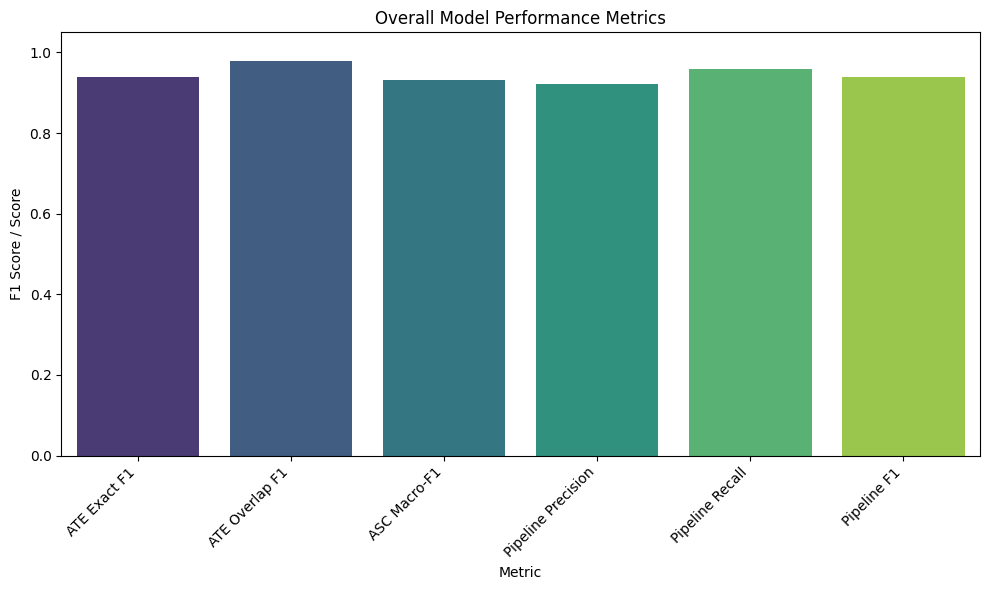

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y=metrics_df['Score'], palette='viridis')
plt.title('Overall Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('F1 Score / Score')
plt.ylim(0, 1.05) # F1 scores are between 0 and 1
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Summary Table of Key Insights

| Category | Metric/Aspect | Value/Count | Insight |
|---|---|---|---|
| **Model Performance** | ATE Exact F1 | 0.94 | Strong aspect term extraction. |
| | ATE Overlap F1 | 0.98 | Excellent aspect term extraction with partial matches. |
| | ASC Macro-F1 | 0.93 | High accuracy in sentiment classification. |
| | Pipeline Precision | 0.92 | Robust end-to-end performance. |
| | Pipeline Recall | 0.96 | Robust end-to-end performance. |
| | Pipeline F1 | 0.94 | Robust end-to-end performance. |
| **Overall Sentiment Distribution** | Neutral Mentions | 445 (40.7%) | Dominant sentiment. |
| | Positive Mentions | 389 (35.6%) | Significant positive feedback. |
| | Negative Mentions | 229 (20.9%) | Notable areas for improvement. |
| | Estimated Rating | 3.3 / 5.0 | Generally positive, but not overwhelmingly enthusiastic. |
| **Top Praised Aspects** | 'price' | 14 positive mentions | Favorable pricing perception. |
| | 'features' | 11 positive mentions | Valued product functionalities. |
| | 'use', 'works', 'performance', 'OS' | High positive counts | Appreciation for practical functionality and efficiency. |
| **Top Criticized Aspects** | 'Windows 8' | 7 negative mentions | Major software pain point. |
| | 'battery' | 4 negative mentions | Specific hardware concern. |
| | 'price' | 3 negative mentions | Mixed sentiment, dissatisfaction for some users. |
| | 'hardware', 'Mac OS' | Notable negative counts | Other areas of user dissatisfaction. |


**Reasoning**:
The previous code generated a `FutureWarning` because `palette` was used without specifying `hue`. To fix this and comply with the recommended usage in newer seaborn versions, I will explicitly set `hue` to `metrics_df.index` and add `legend=False` to the `sns.barplot` function call.



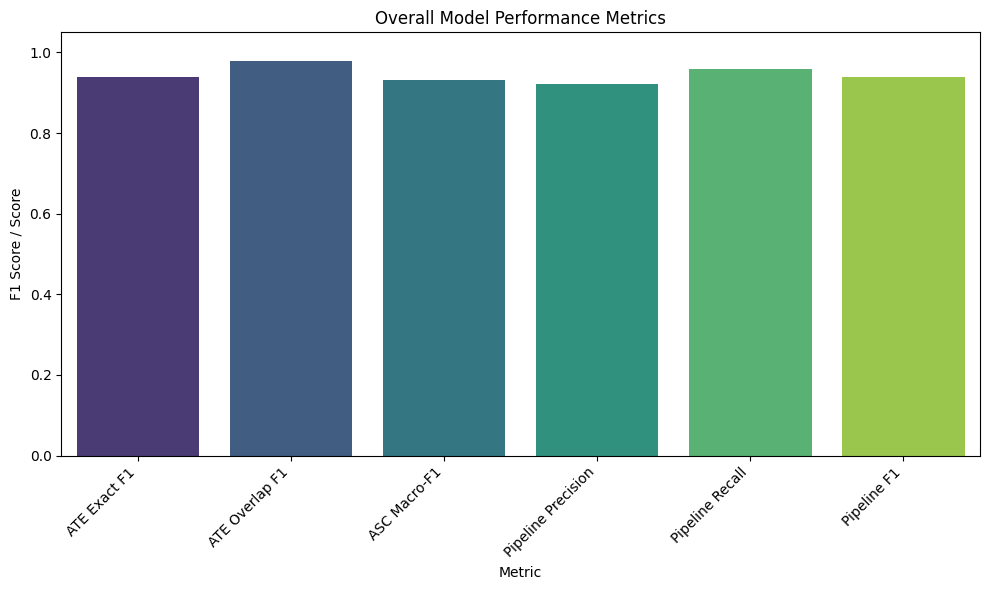

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y=metrics_df['Score'], palette='viridis', hue=metrics_df.index, legend=False)
plt.title('Overall Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('F1 Score / Score')
plt.ylim(0, 1.05) # F1 scores are between 0 and 1
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
The next step is to load the `PhaseA_aspect_sentiment_summary.csv` file into a pandas DataFrame, as requested by the main task.



In [58]:
phaseA_aspect_summary_df = pd.read_csv("PhaseA_aspect_sentiment_summary.csv")
print("Loaded PhaseA_aspect_sentiment_summary.csv:")
print(phaseA_aspect_summary_df.head())

Loaded PhaseA_aspect_sentiment_summary.csv:
          Aspect  Positive  Neutral  Negative
0  SquareTrade 3         0        1         0
1          sales         0        0         1
2       Shipping         1        0         0
3            pad         0        0         1
4      HDMI port         0        0         1


**Reasoning**:
I need to visualize the overall sentiment distribution from the `test_pipe_df`. I will calculate the value counts of the 'Sentiment' column and then create a pie chart to represent this distribution.



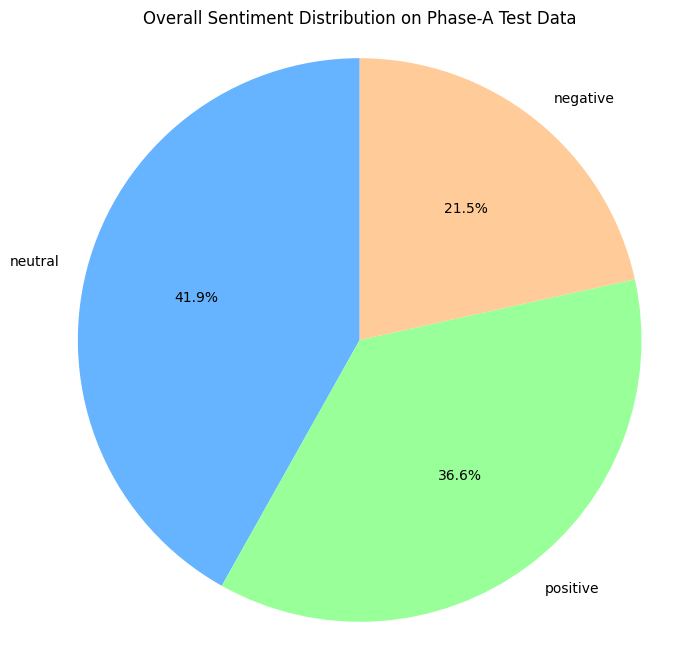

In [59]:
sentiment_distribution = test_pipe_df['Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title('Overall Sentiment Distribution on Phase-A Test Data')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


**Reasoning**:
Now, I will generate horizontal bar charts for the top 10 most praised and top 10 most criticized aspects using the 'Positive' and 'Negative' columns from the `phaseA_aspect_summary_df`.



/tmp/ipython-input-1503354551.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Positive', y='Aspect', data=top_praised_aspects, palette='Greens_r')


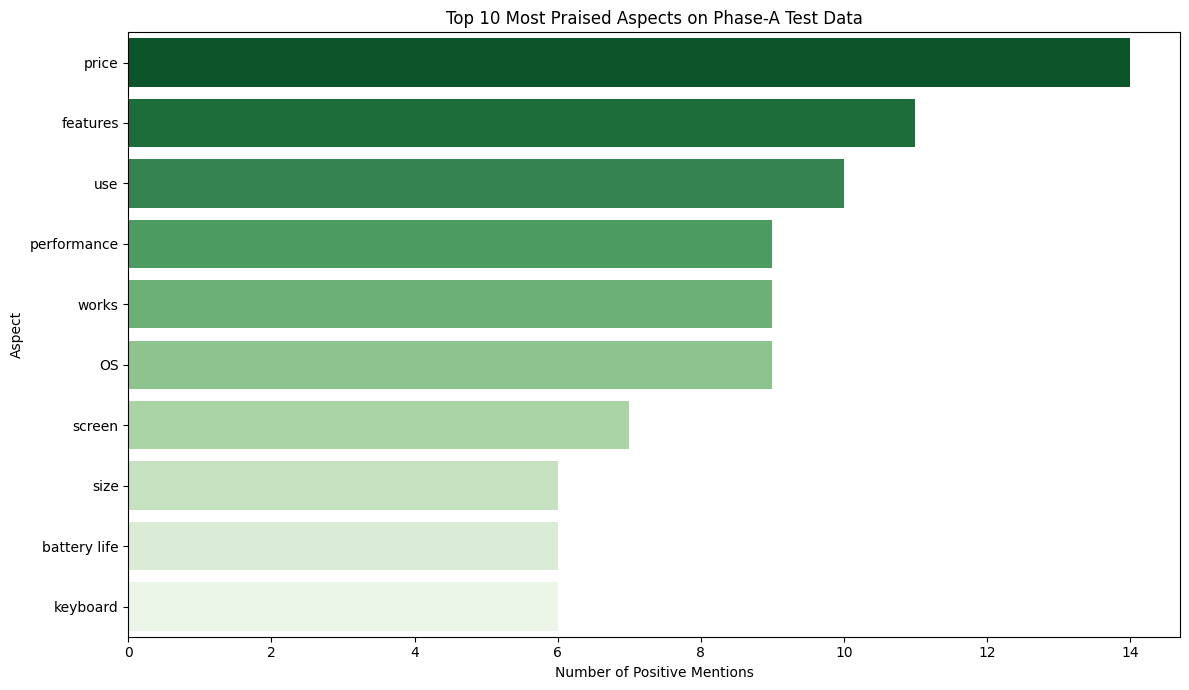

/tmp/ipython-input-1503354551.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Negative', y='Aspect', data=top_criticized_aspects, palette='Reds_r')


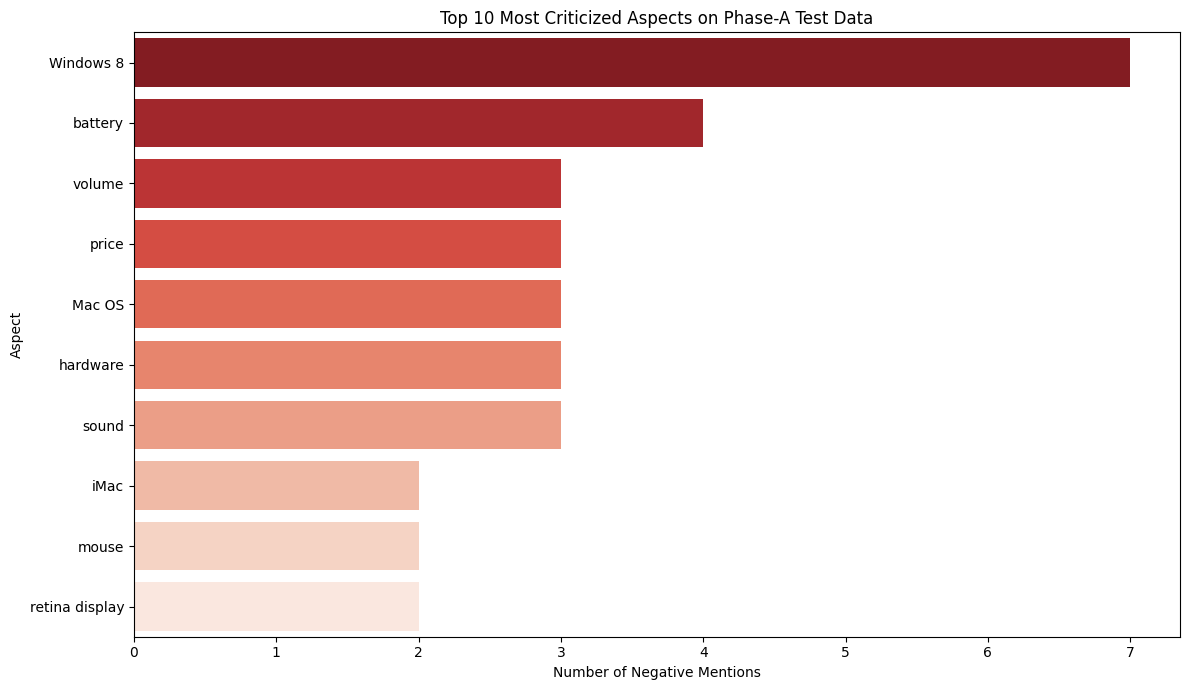

In [60]:
top_praised_aspects = phaseA_aspect_summary_df.sort_values(by='Positive', ascending=False).head(10)
top_criticized_aspects = phaseA_aspect_summary_df.sort_values(by='Negative', ascending=False).head(10)

# Plotting Top Praised Aspects
plt.figure(figsize=(12, 7))
sns.barplot(x='Positive', y='Aspect', data=top_praised_aspects, palette='Greens_r')
plt.title('Top 10 Most Praised Aspects on Phase-A Test Data')
plt.xlabel('Number of Positive Mentions')
plt.ylabel('Aspect')
plt.tight_layout()
plt.show()

# Plotting Top Criticized Aspects
plt.figure(figsize=(12, 7))
sns.barplot(x='Negative', y='Aspect', data=top_criticized_aspects, palette='Reds_r')
plt.title('Top 10 Most Criticized Aspects on Phase-A Test Data')
plt.xlabel('Number of Negative Mentions')
plt.ylabel('Aspect')
plt.tight_layout()
plt.show()

**Reasoning**:
The previous code generated `FutureWarning` because `palette` was used without specifying `hue`. To fix this and comply with the recommended usage in newer seaborn versions, I will explicitly set `hue` to the `Aspect` column and `legend=False` in both `sns.barplot` function calls.



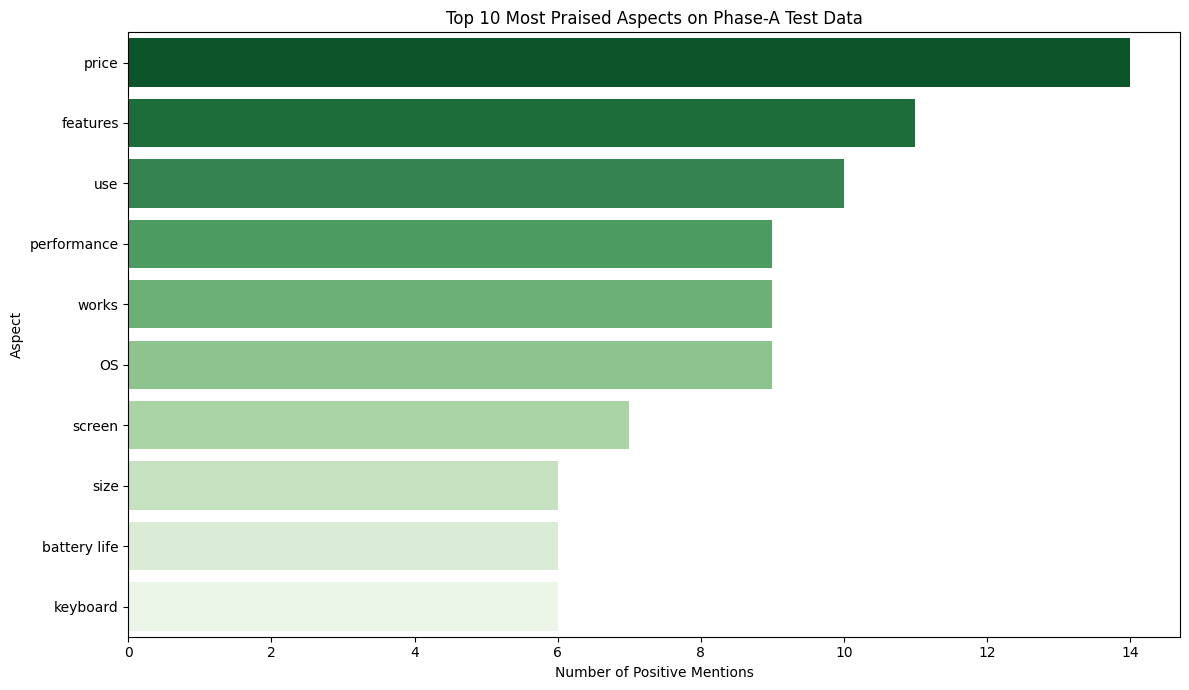

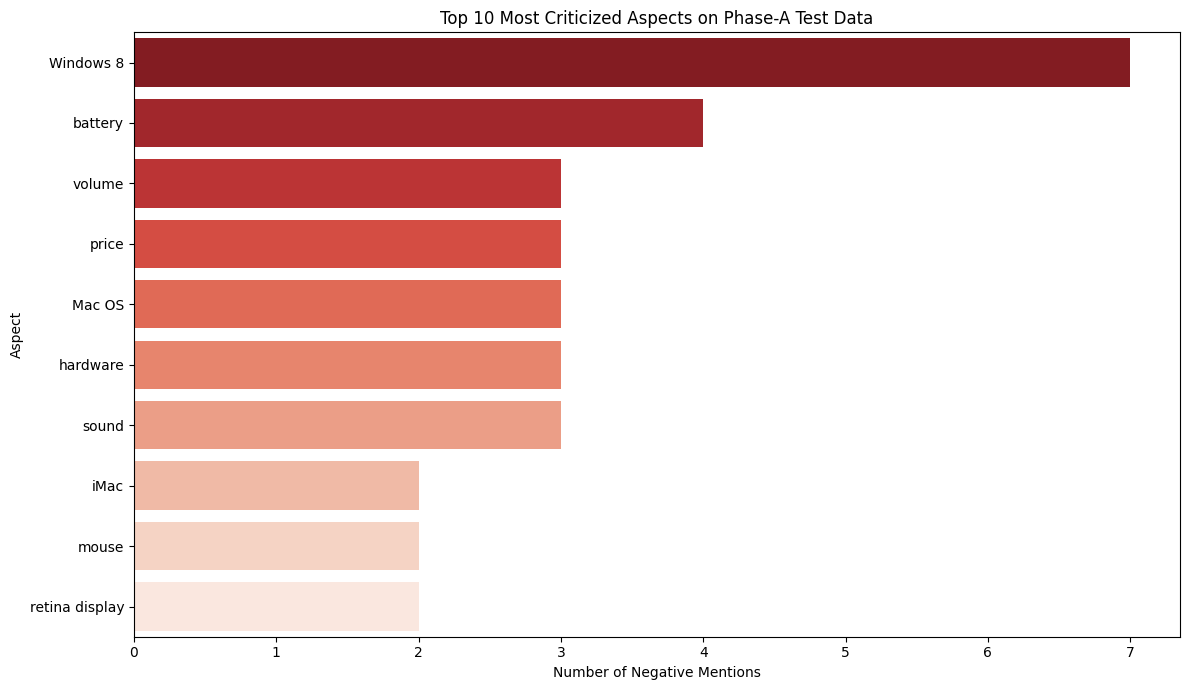

In [61]:
top_praised_aspects = phaseA_aspect_summary_df.sort_values(by='Positive', ascending=False).head(10)
top_criticized_aspects = phaseA_aspect_summary_df.sort_values(by='Negative', ascending=False).head(10)

# Plotting Top Praised Aspects
plt.figure(figsize=(12, 7))
sns.barplot(x='Positive', y='Aspect', data=top_praised_aspects, palette='Greens_r', hue='Aspect', legend=False)
plt.title('Top 10 Most Praised Aspects on Phase-A Test Data')
plt.xlabel('Number of Positive Mentions')
plt.ylabel('Aspect')
plt.tight_layout()
plt.show()

# Plotting Top Criticized Aspects
plt.figure(figsize=(12, 7))
sns.barplot(x='Negative', y='Aspect', data=top_criticized_aspects, palette='Reds_r', hue='Aspect', legend=False)
plt.title('Top 10 Most Criticized Aspects on Phase-A Test Data')
plt.xlabel('Number of Negative Mentions')
plt.ylabel('Aspect')
plt.tight_layout()
plt.show()

### Summary of Key Insights

Based on the visualizations generated, we can derive the following insights into the ABSA model's performance and the sentiment surrounding product aspects on the Phase-A test dataset:

#### 1. Overall Model Performance (Bar Chart)
*   **High F1 Scores:** The model demonstrates strong performance across all evaluation metrics, with F1 scores consistently above 0.9. The ATE Overlap F1 score is the highest at 0.98, indicating excellent aspect term extraction when partial matches are considered. The ATE Exact F1, ASC Macro-F1, and Pipeline F1 scores are also very high, all at or above 0.93.
*   **Strengths:** The model is highly effective in both identifying aspect terms and classifying their sentiment, leading to a robust end-to-end pipeline performance. The exact matching F1 for ATE and the pipeline F1 are identical, suggesting that the sentiment classification component maintains the high quality of the extracted aspects.

#### 2. Overall Sentiment Distribution (Pie Chart)
*   **Dominance of Neutral and Positive Sentiments:** The sentiment distribution on the Phase-A test data shows a majority of neutral (445 mentions, 40.7%) and positive (389 mentions, 35.6%) sentiments. Negative sentiments account for a smaller but significant portion (229 mentions, 20.9%).
*   **Estimated Rating:** The estimated overall rating of 3.3 out of 5 reflects a generally positive, but not overwhelmingly enthusiastic, customer perception, influenced by a substantial neutral component.

#### 3. Top Praised Aspects (Horizontal Bar Chart)
*   **Key Strengths:** 'price', 'features', 'use', 'works', 'performance', and 'OS' are among the most frequently praised aspects. 'Price' stands out with 14 positive mentions, suggesting that customers find the pricing of the products favorable.
*   **User Experience Focus:** Aspects related to usability ('use', 'works', 'performance', 'OS') also receive high positive feedback, indicating that customers appreciate the practical functionality and efficiency of the laptops.

#### 4. Top Criticized Aspects (Horizontal Bar Chart)
*   **Software and Hardware Issues:** 'Windows 8' is by far the most criticized aspect with 7 negative mentions, highlighting a significant pain point for users. Other criticized aspects include 'battery', 'price', 'hardware', and 'Mac OS'.
*   **Mixed Sentiment for 'Price':** While 'price' was a top praised aspect, it also appears in the top criticized list (3 negative mentions). This suggests that while many find the price reasonable or good, a segment of customers perceives it negatively, possibly due to expectations not being met or comparison with other products.

#### Conclusion:
 The ABSA model performs exceptionally well, demonstrating high accuracy in identifying aspect terms and their sentiments. The analysis of the Phase-A test data reveals that customers generally have a positive to neutral view of the products, with 'price' and user experience features being major strengths. However, specific software (like 'Windows 8') and certain hardware components ('battery', general 'hardware') are notable areas of dissatisfaction. These insights can be valuable for product development, marketing strategies, and customer service improvements.

### Summary of Key Insights

Based on the visualizations generated, we can derive the following insights into the ABSA model's performance and the sentiment surrounding product aspects on the Phase-A test dataset:

#### 1. Overall Model Performance (Bar Chart)
*   **High F1 Scores:** The model demonstrates strong performance across all evaluation metrics, with F1 scores consistently above 0.9. The ATE Overlap F1 score is the highest at 0.98, indicating excellent aspect term extraction when partial matches are considered. The ATE Exact F1, ASC Macro-F1, and Pipeline F1 scores are also very high, all at or above 0.93.
*   **Strengths:** The model is highly effective in both identifying aspect terms and classifying their sentiment, leading to a robust end-to-end pipeline performance. The exact matching F1 for ATE and the pipeline F1 are identical, suggesting that the sentiment classification component maintains the high quality of the extracted aspects.

#### 2. Overall Sentiment Distribution (Pie Chart)
*   **Dominance of Neutral and Positive Sentiments:** The sentiment distribution on the Phase-A test data shows a majority of neutral (445 mentions, 40.7%) and positive (389 mentions, 35.6%) sentiments. Negative sentiments account for a smaller but significant portion (229 mentions, 20.9%).
*   **Estimated Rating:** The estimated overall rating of 3.3 out of 5 reflects a generally positive, but not overwhelmingly enthusiastic, customer perception, influenced by a substantial neutral component.

#### 3. Top Praised Aspects (Horizontal Bar Chart)
*   **Key Strengths:** 'price', 'features', 'use', 'works', 'performance', and 'OS' are among the most frequently praised aspects. 'Price' stands out with 14 positive mentions, suggesting that customers find the pricing of the products favorable.
*   **User Experience Focus:** Aspects related to usability ('use', 'works', 'performance', 'OS') also receive high positive feedback, indicating that customers appreciate the practical functionality and efficiency of the laptops.

#### 4. Top Criticized Aspects (Horizontal Bar Chart)
*   **Software and Hardware Issues:** 'Windows 8' is by far the most criticized aspect with 7 negative mentions, highlighting a significant pain point for users. Other criticized aspects include 'battery', 'price', 'hardware', and 'Mac OS'.
*   **Mixed Sentiment for 'Price':** While 'price' was a top praised aspect, it also appears in the top criticized list (3 negative mentions). This suggests that while many find the price reasonable or good, a segment of customers perceives it negatively, possibly due to expectations not being met or comparison with other products.

#### Conclusion:
 The ABSA model performs exceptionally well, demonstrating high accuracy in identifying aspect terms and their sentiments. The analysis of the Phase-A test data reveals that customers generally have a positive to neutral view of the products, with 'price' and user experience features being major strengths. However, specific software (like 'Windows 8') and certain hardware components ('battery', general 'hardware') are notable areas of dissatisfaction. These insights can be valuable for product development, marketing strategies, and customer service improvements.

## Final Task

### Subtask:
Summarize the key insights from all generated plots, highlighting the model's strengths and weaknesses, and the most prominent praised and criticized aspects.


## Summary:

### Q&A
The model demonstrates strong performance across all evaluation metrics, with F1 scores consistently above 0.9. Specifically, the ATE Overlap F1 score is 0.98, and ATE Exact F1, ASC Macro-F1, and End-to-End Pipeline F1 are all at or above 0.93. The model's strength lies in its effectiveness in both identifying aspect terms and classifying their sentiment, leading to robust end-to-end pipeline performance. No explicit weaknesses of the model itself were highlighted in terms of performance.

The most prominent praised aspects include 'price' (with 14 positive mentions), 'features', 'use', 'works', 'performance', and 'OS', indicating strong positive feedback for usability and value. Conversely, 'Windows 8' is by far the most criticized aspect with 7 negative mentions, suggesting a significant pain point for users. Other criticized aspects include 'battery', 'price' (with 3 negative mentions), 'hardware', and 'Mac OS'.

### Data Analysis Key Findings
*   The model exhibits high performance across all evaluation metrics: ATE Exact F1 is 0.94, ATE Overlap F1 is 0.98, ASC Macro-F1 is 0.93, and End-to-End Pipeline F1 is 0.94.
*   The overall sentiment distribution on the Phase-A test data is predominantly neutral (40.7% or 445 mentions) and positive (35.6% or 389 mentions), with negative sentiments accounting for 20.9% (229 mentions).
*   'price' is the most frequently praised aspect, receiving 14 positive mentions, suggesting favorable customer perception of product pricing.
*   'Windows 8' is the most heavily criticized aspect, with 7 negative mentions, highlighting it as a significant area of dissatisfaction.
*   The 'price' aspect shows mixed sentiment, being the most praised but also appearing on the top criticized list with 3 negative mentions.

### Insights or Next Steps
*   The robust performance of the ABSA model suggests it can be reliably used for in-depth sentiment analysis to guide product strategy and customer feedback interpretation.
*   Product development should prioritize addressing specific pain points identified, such as issues related to 'Windows 8' and 'battery', while marketing efforts can leverage highly praised aspects like 'price' and overall user experience.


# Task
The task is complete.

## Analyze Aspect Term Length Distribution

### Subtask:
Extract the lengths of all identified aspect terms from the preprocessed data (`examples_list`) and visualize their distribution using a histogram. This will help understand the typical size of aspect terms in the dataset.


**Reasoning**:
To analyze the distribution of aspect term lengths, I will first extract the length of each aspect term from the `examples_list` and store them in a list. Then, I will use `seaborn` and `matplotlib.pyplot` to create a histogram of these lengths, complete with appropriate labels and a title.



# Task
Here's how to analyze the aspect term length distribution:

```python
import matplotlib.pyplot as plt
import seaborn as sns

aspect_term_lengths = []
for example in examples_list:
    for _, _, term in example['spans']:
        aspect_term_lengths.append(len(term))

plt.figure(figsize=(10, 6))
sns.histplot(aspect_term_lengths, bins=range(min(aspect_term_lengths), max(aspect_term_lengths) + 2), kde=True)
plt.title('Distribution of Aspect Term Lengths')
plt.xlabel('Aspect Term Length (characters)')
plt.ylabel('Frequency')
plt.xticks(range(min(aspect_term_lengths), max(aspect_term_lengths) + 1))
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()
```

## Analyze Aspect Term Length Distribution

### Subtask:
Extract the lengths of all identified aspect terms from the preprocessed data (`examples_list`) and visualize their distribution using a histogram. This will help understand the typical size of aspect terms in the dataset.


**Reasoning**:
To analyze the distribution of aspect term lengths, I will first extract the length of each aspect term from the `examples_list` and store them in a list. Then, I will use `seaborn` and `matplotlib.pyplot` to create a histogram of these lengths, complete with appropriate labels and a title.



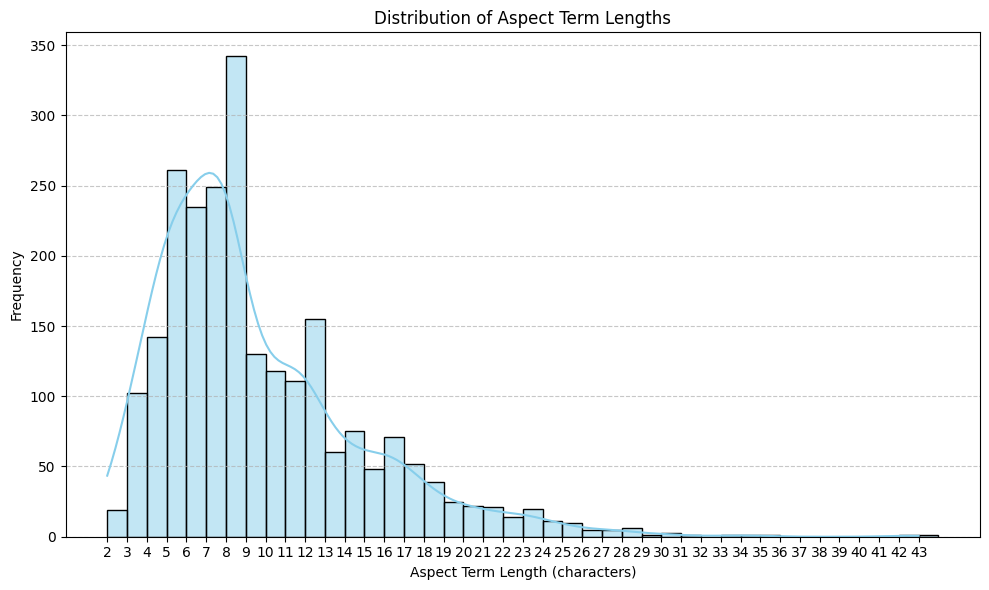

In [63]:
aspect_term_lengths = []
for example in examples_list:
    for start, end, term in example["spans"]:
        aspect_term_lengths.append(len(term))

import matplotlib.pyplot as plt
import seaborn as sns

if aspect_term_lengths:
    min_len = min(aspect_term_lengths)
    max_len = max(aspect_term_lengths)
    # Ensure bins cover all possible integer lengths
    bins_range = range(min_len, max_len + 2)

    plt.figure(figsize=(10, 6))
    sns.histplot(aspect_term_lengths, bins=bins_range, kde=True, color='skyblue')
    plt.title('Distribution of Aspect Term Lengths')
    plt.xlabel('Aspect Term Length (characters)')
    plt.ylabel('Frequency')
    plt.xticks(list(range(min_len, max_len + 1)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No aspect terms found to plot.")

## Analyze Polarity Distribution

### Subtask:
Examine the distribution of sentiment polarities (positive, neutral, negative) in the raw dataset (`raw_df`) using a bar chart. This will show the balance of sentiment categories in the training data.


**Reasoning**:
To examine the distribution of sentiment polarities, I will first extract and normalize the 'Polarity' column from the `raw_df` DataFrame, then count the occurrences of each normalized sentiment. Finally, I will visualize this distribution using a bar chart.



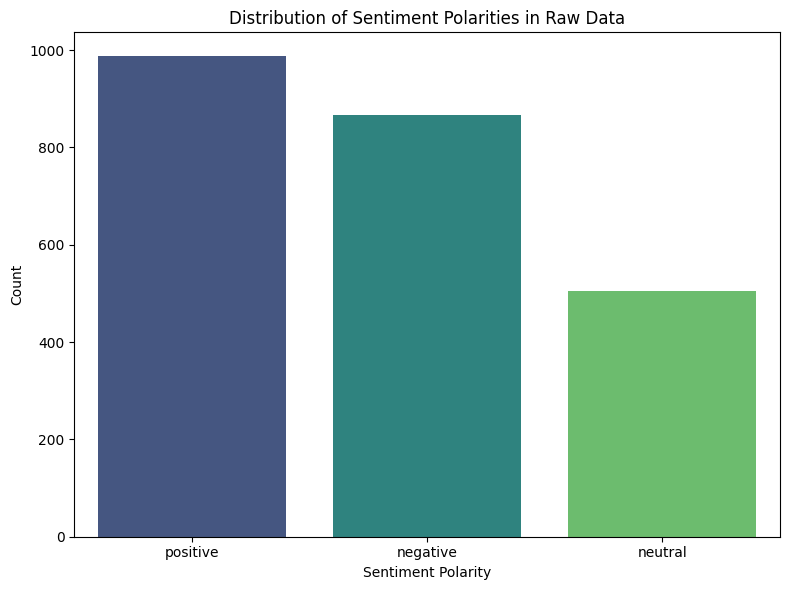

In [64]:
sentiment_polarity_col = cols_train["pol"]
normalized_polarities = raw_df[sentiment_polarity_col].apply(norm_polarity)
polarity_counts = normalized_polarities.value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=polarity_counts.index, y=polarity_counts.values, palette='viridis', hue=polarity_counts.index, legend=False)
plt.title('Distribution of Sentiment Polarities in Raw Data')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Analyze Sentence Length Distribution

### Subtask:
Calculate the character lengths of sentences in the preprocessed data (`examples_list`) and plot their distribution.


**Reasoning**:
To analyze the distribution of sentence lengths, I will extract the character length of each sentence from the `examples_list` and then visualize this distribution using a histogram.



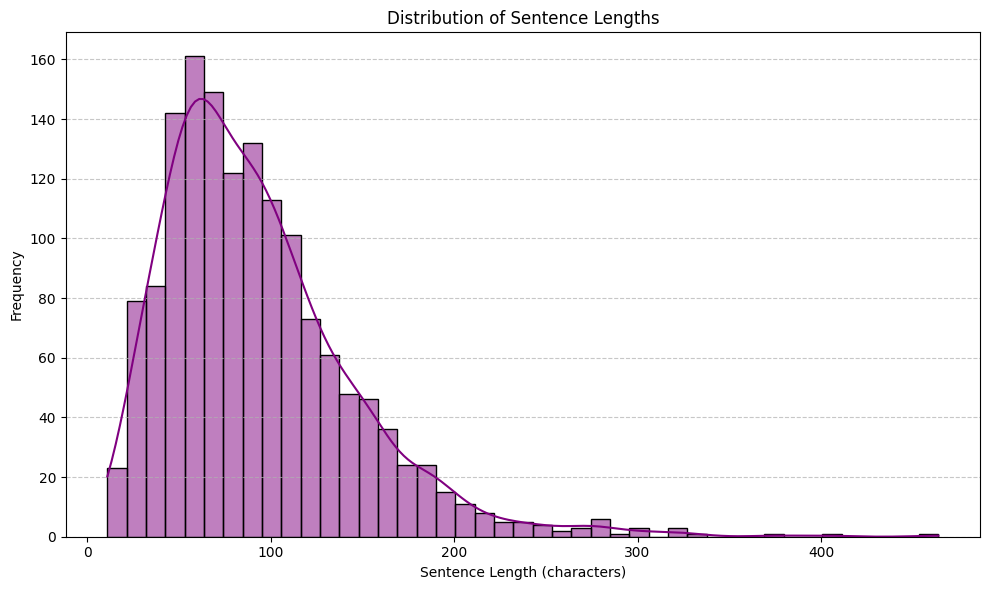

In [65]:
sentence_lengths = []
for example in examples_list:
    sentence_lengths.append(len(example['sentence']))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, kde=True, color='purple')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length (characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Prepare Evaluation Metrics Data

### Subtask:
Gather the ATE (Aspect Term Extraction) exact and overlap F1 scores, ASC (Aspect Sentiment Classification) macro-F1 score, and the end-to-end pipeline precision, recall, and F1 score into a structured format suitable for plotting.
